# Differential Dynamic Microscopy {-}

Here, we go through the steps of performing DDM analysis with the PyDDM package as detailed in our JoVE manuscript. 

## 1. Software installation {-}

We will need to import [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [xarray](https://xarray.pydata.org/en/stable/), and 
[yaml](https://pyyaml.org/). 
We will also import the [PyDDM](https://rmcgorty.github.io/PyDDM/) package. If a `ModuleNotFoundError` comes up, you may need to install one of these packages.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import yaml
import sys
sys.path.append("../PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

import pandas as pd
pd.set_option('display.latex.repr', True)
pd.set_option('display.latex.longtable', True)

In [2]:
#Just for formating this notebook, not necessary for the DDM analysis
import IPython.display
from IPython.display import Markdown

## 2. Planning the imaging session {-}

### 2.1 Length scales probed {-}

In [3]:
pixel_size = 0.13 #Size of pixel in microns
image_dimension = 512 #Size of image in pixels (one dimension), assumed to be square
numerical_aperture = 1.4 #NA of the imaging objective lens
wavelength_of_light = 0.550 #wavelength of light in microns

wavevector_q = np.arange(0,image_dimension/2)*2*np.pi* \
               (1./(image_dimension*pixel_size))
max_q_based_on_NA = 2*np.pi*numerical_aperture/wavelength_of_light

IPython.display.display(Markdown(\
    rf"Minimum wavevector: ${wavevector_q[1]:.2f}\; \mu$"r"$m^{-1}$"))
IPython.display.display(Markdown(\
    rf"Maximum wavevector: ${wavevector_q[-1]:.2f}\; \mu$"r"$m^{-1}$"))
IPython.display.display(Markdown(\
    rf"Maximum wavevector based on optical resolution: ${max_q_based_on_NA:.2f}\; \mu$"r"$m^{-1}$"))

Minimum wavevector: $0.09\; \mu$$m^{-1}$

Maximum wavevector: $24.07\; \mu$$m^{-1}$

Maximum wavevector based on optical resolution: $15.99\; \mu$$m^{-1}$

The range of accessbible $q$-values is determined by the image dimension and the pixel size. The maximum $q$ may also be limited by the optical resolution of the microscope, which is determined by the numerical aperature of the microscope's lens system and the wavelength of light.

### 2.2 Time scales probed {-}

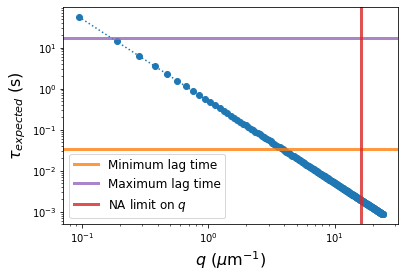

In [4]:
frame_rate = 30 #Frame rate (frames per second) used 
maximum_lag_frame = 500 #Maximum lag time in frames

min_lag_time = 1.0/frame_rate
max_lag_time = maximum_lag_frame / frame_rate

expected_diffusion_coefficient = 2.0 #diffusion coeff 
# Units should be in microns squared per second

expected_decay_time = \
    (wavevector_q[1:]**2 * expected_diffusion_coefficient)**-1

fig,ax = plt.subplots()
ax.loglog(wavevector_q[1:], expected_decay_time, 
          ':o', color='tab:blue')
ax.set_xlabel("$q$ ($\mu$m$^{-1}$)", 
             fontsize=16)
ax.set_ylabel("$\\tau_{expected}$ (s)",
             fontsize=16)
ax.axhline(y = min_lag_time, color='tab:orange', 
           lw=3, alpha=0.8, label="Minimum lag time")
ax.axhline(y = max_lag_time, color='tab:purple', 
           lw=3, alpha=0.8, label='Maximum lag time')
ax.axvline(x = max_q_based_on_NA, color='tab:red', 
           lw=3, alpha=0.8, label='NA limit on $q$')
plt.legend(loc=0, fontsize=12)

## 3. Image acquisition {-}

Based on the above analysis of the time and length scales accessible given frame rate, image series duration, and pixel size, acquire image sequence of, typically, at least 1000 frames. 

## 4. Parameter setup {-}

### 4.1 Copy the YAML file provided {-}

Make a copy of the file `example_parameter_file.yml` which can be found in the GitHub [PyDDM repository](https://github.com/rmcgorty/PyDDM). Modify the copied file with your values for the different parameters. 

Alternatively, one can create a Python dictionary of the metadata and parameters. To do so, we can create strings which make exactly the syntax used in the YAML file and then convert these strings to a dictionary. This method is what is shown below.

### 4.2 Image metadata {-}

In [5]:
parameters_data_location = """
DataDirectory: './'
FileName: 'images_nobin_40x_128x128_8bit.tif'
"""

parameters_image_metadata = """
Metadata:
  pixel_size: 0.242 # size of pixel in um
  frame_rate: 41.7 #frames per second
"""

For the DDM analysis, we must provide the `DataDirectory` and `FileName` for the data to analyze. Note that the image files may either be in TIFF format or ND2 format. 

Metadata for the recorded images must include `pixel_size` and `frame_rate`. The assumed units for these parameters are microns and frames per second, respectively.

### 4.2 Analysis parameters {-}

In [6]:
parameters_analysis = """
Analysis_parameters:
  number_lag_times: 40
  last_lag_time: 600
"""

Set the parameters for calculating the DDM matrix. In addition to the setting the number of lag times and the longest lag time to use, there are several other optional parameters that can be set. 

### 4.3 Fitting parameters {-}

In [7]:
parameters_fitting = """
Fitting_parameters:
  model: 'DDM Matrix - Single Exponential' 
  Tau: [1.0, 0.001, 10]
  StretchingExp: [1.0, 0.5, 1.1]
  Amplitude: [1e2, 1, 1e6]
  Background: [2.5e4, 0, 1e7]
"""

Set the parameters for fitting the DDM matrix or the intermediate scattering function (ISF). Also, for each parameter in the model, specify the initial guess, lower bound, and upper bound. 

For a list of possible models to use, run the `print_fitting_models` function as shown below.

In [8]:
ddm.print_fitting_models()

1: 'DDM Matrix - Single Exponential'
2: 'DDM Matrix - Double Exponential'
3: 'DDM Matrix - Exponential and Ballistic'
4: 'DDM Matrix - Ballistic'
5: 'DDM Matrix - Double Ballistic'
6: 'DDM Matrix - Single Exponential - NonErgodic'
7: 'ISF - Single Exponential'
8: 'ISF - Double Exponential'
9: 'ISF - Exponential and Ballistic'
10: 'ISF - Ballistic'
11: 'ISF - Double Ballistic'
12: 'ISF - Single Exponential - NonErgodic'


## 5. Calculating the DDM matrix {-}

### 5.1 Initialize the analysis class {-}

In [9]:
#First, concatenate the strings specifying the metadata and parameters
ddm_analysis_parameters_str = parameters_data_location + \
                              parameters_image_metadata + \
                              parameters_analysis + parameters_fitting

#Convert that string to a Python dictionary
parameters_as_dictionary = yaml.safe_load(ddm_analysis_parameters_str)

#Note that one could also pass to `DDM_Analysis` the path to the 
# YAML file containing the metadata and parameters
ddm_calc = ddm.DDM_Analysis(parameters_as_dictionary)

Provided metadata: {'pixel_size': 0.242, 'frame_rate': 41.7}
Image shape: 3000-by-128-by-128
Number of frames to use for analysis: 3000
Maximum lag time (in frames): 600
Number of lag times to compute DDM matrix: 40
Using the full frame, dimensions: 128-by-128.


### 5.2 Calculate the DDM matrix {-}

DDM matrix took 90.88063144683838 seconds to compute.
 Background estimate ± std is 211.17 ± 1.49


<xarray.Dataset>
Dimensions:           (lagtime: 40, q_y: 128, q_x: 128, q: 64, y: 128, x: 128, frames: 40)
Coordinates:
  * lagtime           (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
    framelag          (frames) int32 1 2 3 4 5 6 7 ... 308 352 402 459 525 599
  * q_y               (q_y) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q_x               (q_x) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 194.5 183.5 ... 192.0 196.8
    ddm_matrix        (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    first_image       (y, x) float64 128.0 149.0 173.0 ... 175.0 229.0 215.0
    avg_image_ft      (q) float64 0.0 1.293e+05 5.225e+03 ... 105.3 104.7 105.3
    num_pairs_per_dt  (lagtime) int32 2999 2998 2997 1498 1498 ... 20 17 15 13
    B                 float64 211.2
    B_std             float64 1.491
    Amplitude         (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    ISF               (lagtime, q) float64 0.0 0.9997 0.9892 ... -4.952 -19.73
Attributes: (12/14)
    units:             Intensity
    lagtime:           sec
    q:                 μm$^{-1}$
    x:                 pixels
    y:                 pixels
    info:              ddm_matrix is the averages of FFT difference images, r...
    ...                ...
    DataDirectory:     ./
    FileName:          images_nobin_40x_128x128_8bit.tif
    pixel_size:        0.242
    frame_rate:        41.7
    number_lag_times:  40
    last_lag_time:     600

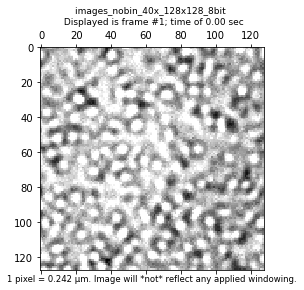

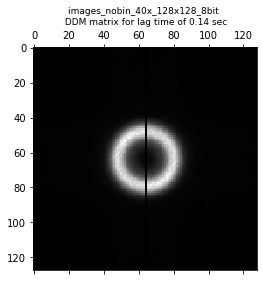

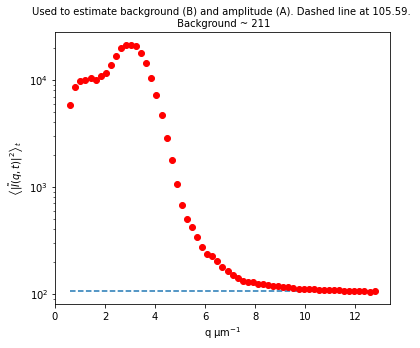

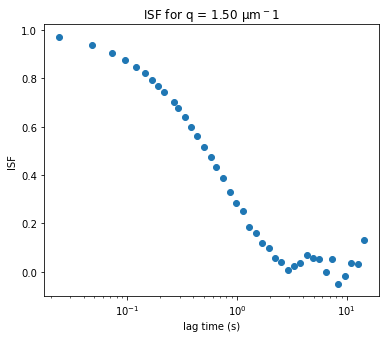

In [10]:
ddm_calc.calculate_DDM_matrix(quiet=True)

Note the four figures which are produced. These will also be saved as a PDF. 

### 5.3 DDM dataset {-}

In [11]:
display(ddm_calc.ddm_dataset)

<xarray.Dataset>
Dimensions:           (lagtime: 40, q_y: 128, q_x: 128, q: 64, y: 128, x: 128, frames: 40)
Coordinates:
  * lagtime           (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
    framelag          (frames) int32 1 2 3 4 5 6 7 ... 308 352 402 459 525 599
  * q_y               (q_y) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q_x               (q_x) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 194.5 183.5 ... 192.0 196.8
    ddm_matrix        (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    first_image       (y, x) float64 128.0 149.0 173.0 ... 175.0 229.0 215.0
    avg_image_ft      (q) float64 0.0 1.293e+05 5.225e+03 ... 105.3 104.7 105.3
    num_pairs_per_dt  (lagtime) int32 2999 2998 2997 1498 1498 ... 20 17 15 13
    B                 float64 211.2
    B_std             float64 1.491
    Amplitude         (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    ISF               (lagtime, q) float64 0.0 0.9997 0.9892 ... -4.952 -19.73
Attributes: (12/14)
    units:             Intensity
    lagtime:           sec
    q:                 μm$^{-1}$
    x:                 pixels
    y:                 pixels
    info:              ddm_matrix is the averages of FFT difference images, r...
    ...                ...
    DataDirectory:     ./
    FileName:          images_nobin_40x_128x128_8bit.tif
    pixel_size:        0.242
    frame_rate:        41.7
    number_lag_times:  40
    last_lag_time:     600

The results are saved in an [xarray Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) format. 

Note the attributes stored (in a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) format) as shown below. 

In [12]:
display(ddm_calc.ddm_dataset.attrs)

{'units': 'Intensity',
 'lagtime': 'sec',
 'q': 'μm$^{-1}$',
 'x': 'pixels',
 'y': 'pixels',
 'info': 'ddm_matrix is the averages of FFT difference images, ravs are the radial averages',
 'BackgroundMethod': 0,
 'OverlapMethod': 2,
 'DataDirectory': './',
 'FileName': 'images_nobin_40x_128x128_8bit.tif',
 'pixel_size': 0.242,
 'frame_rate': 41.7,
 'number_lag_times': 40,
 'last_lag_time': 600}

### 5.4 Amplitude and background parameters {-}

Note that one of the produced figures show a plot of $\left< | \tilde{I}(q,t) |^2 \right>_t$ vs $q$. This is used to estimate the background and amplitude. Other methods of estimating the background $B$ can be used if one sets the parameter `background_method` either in the YAML file or as an optional keyword argument to the function `calculate_DDM_matrix`. 

In [13]:
print("Estimated background: %.1f" % ddm_calc.ddm_dataset.B)

Estimated background: 211.2


## 6. Fitting the DDM matrix or ISF {-}

Here we will be fitting the DDM matrix with the ISF assumed to be a single exponential (since we set `model: 'DDM Matrix - Single Exponential'` in the parameters). So, we will be fitting our DDM matrix, $D(q, \Delta t)$ to 
$$ D(q, \Delta t) = A(q) \left[ 1 - exp(-(\Delta t / \tau(q)^{s(q)}) \right] + B(q) $$
where $A$ is the amplitude, $\tau$ is the characteristic decay time, $s$ is the stretching exponent, and $B$ is the background.

### 6.1 Initiazing DDM_Fit class {-}


In [14]:
ddm_fit = ddm.DDM_Fit(ddm_calc.data_yaml)

,Initial guess,Minimum,Maximum
Amplitude,100.0,1.000,1000000.0
Tau,1.0,0.001,10.0
Background,25000.0,0.000,10000000.0
StretchingExp,1.0,0.500,1.1


Loading file ./images_nobin_40x_128x128_8bit_ddmmatrix.nc ...


### 6.2 Select model {-}

In [15]:
ddm_fit.reload_fit_model_by_name('DDM Matrix - Single Exponential')

,Initial guess,Minimum,Maximum
Amplitude,100.0,1.000,1000000.0
Tau,1.0,0.001,10.0
Background,25000.0,0.000,10000000.0
StretchingExp,1.0,0.500,1.1


The model to be used is specified in the YAML file. However, one can select a different model after the YAML file has been loaded using the `reload_fit_model_by_name` function as shown above. 

### 6.3 Setting intial guesses and bounds {-}

In [16]:
ddm_fit.set_parameter_initial_guess('Tau', 2)

Parameter 'Tau' set to 2.


The initial guesses for all parameters along with the lower and upper bounds should be set in the YAML file. However, if one would like to change those values or if one uses a new model which contains additional parameters, these values can be set using the `set_parameter_initial_guess` and `set_parameter_bounds` functions.

### 6.4 Fit the data {-}

In [17]:
fit01 = ddm_fit.fit()

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit01'.


,q,Amplitude,Tau,Background,StretchingExp
0,0.000000,1.000000,10.000000,0.000000,1.100000
1,0.202840,5009.160961,10.000000,125.265536,0.500000
2,0.405681,8482.808494,10.000000,0.000000,0.525256
3,0.608521,10442.590887,3.868067,110.613239,0.710762
4,0.811362,16595.852259,2.556070,83.269654,0.811578
5,1.014202,18774.162142,1.424364,101.316234,0.909133
6,1.217043,20126.209593,1.035536,37.942256,0.911751
7,1.419883,20269.935160,0.742219,30.165762,0.952913
8,1.622723,19408.933977,0.552100,0.000000,0.955882
9,1.825564,21442.103308,0.465083,0.000000,0.977973


In [18]:
pd = ddm.hf.generate_pandas_data(fit01)
pd[2:].head(n=10)

,q,Amplitude,Tau,Background,StretchingExp
2,0.405681,8482.808494,10.000000,1.683886e-07,0.525256
3,0.608521,10442.590887,3.868067,1.106132e+02,0.710762
4,0.811362,16595.852259,2.556070,8.326965e+01,0.811578
5,1.014202,18774.162142,1.424364,1.013162e+02,0.909133
6,1.217043,20126.209593,1.035536,3.794226e+01,0.911751
7,1.419883,20269.935160,0.742219,3.016576e+01,0.952913
8,1.622723,19408.933977,0.552100,1.059696e-16,0.955882
9,1.825564,21442.103308,0.465083,6.213736e-14,0.977973
10,2.028404,23388.120232,0.396199,3.670560e-16,0.968451
11,2.231245,27490.759692,0.321218,3.120679e-12,1.008676


To output a nicely formatted table of the best fit paramters for each value of $q$, we can create a [pandas DataFrame](https://pandas.pydata.org/docs/reference/frame.html) as shown above. 

## 7. Interpreting the fit results {-}

### 7.1 Generating figures {-}

In function 'get_tau_vs_q_fit', using new tau...
In hf.plot_one_tau_vs_q function, using new tau... 


<xarray.Dataset>
Dimensions:          (parameter: 4, q: 64, lagtime: 40)
Coordinates:
  * parameter        (parameter) <U13 'Amplitude' 'Tau' ... 'StretchingExp'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 1.0 5.009e+03 ... 0.9077 0.9903
    theory           (lagtime, q) float64 0.001311 364.7 349.3 ... 206.3 206.3
    isf_data         (lagtime, q) float64 0.0 0.9997 0.9892 ... -4.952 -19.73
    ddm_matrix_data  (lagtime, q) float64 0.0 294.2 321.4 ... 207.8 201.1 200.4
    A                (q) float64 -211.2 2.585e+05 1.024e+04 ... -1.699 -0.52
    B                float64 211.2
Attributes: (12/18)
    model:                          DDM Matrix - Single Exponential
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [1.0...
    effective_diffusion_coeff:      0.6132831943245276
    tau_vs_q_slope:                 [-1.92879196]
    msd_alpha:                      [1.03691847]
    ...                             ...
    DataDirectory:                  ./
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7
    BackgroundMethod:               0
    OverlapMethod:                  2

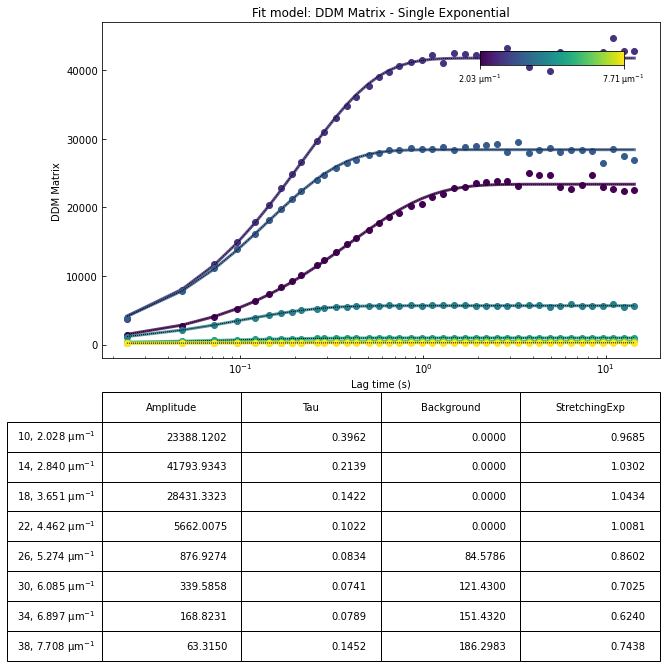

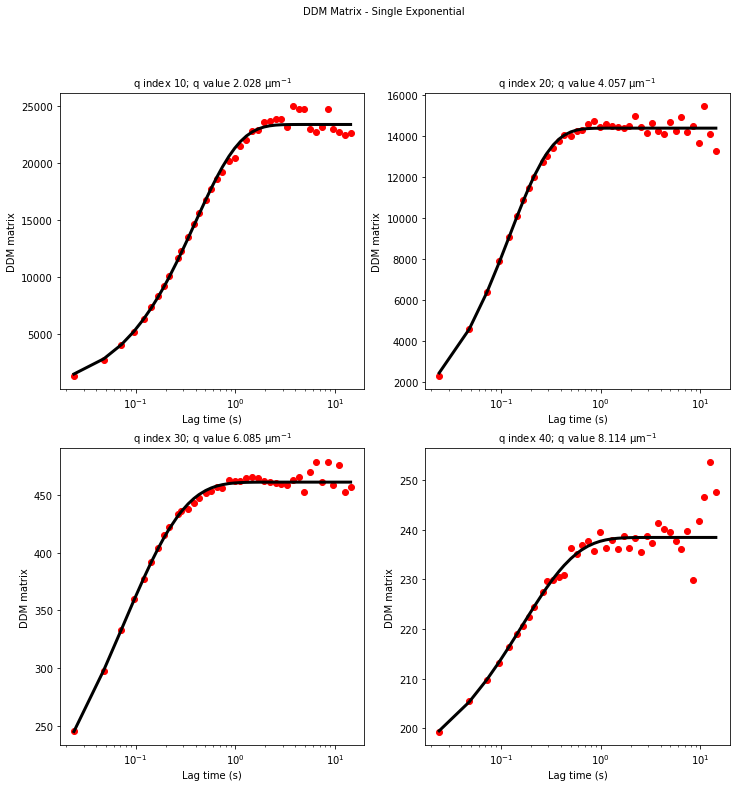

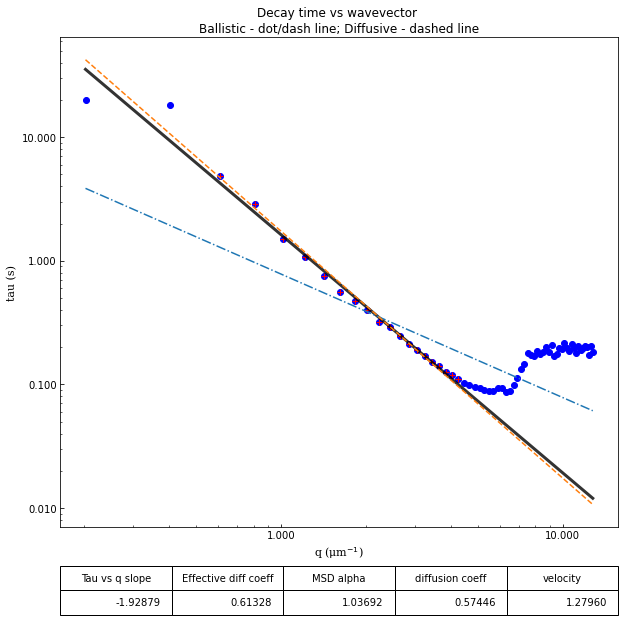

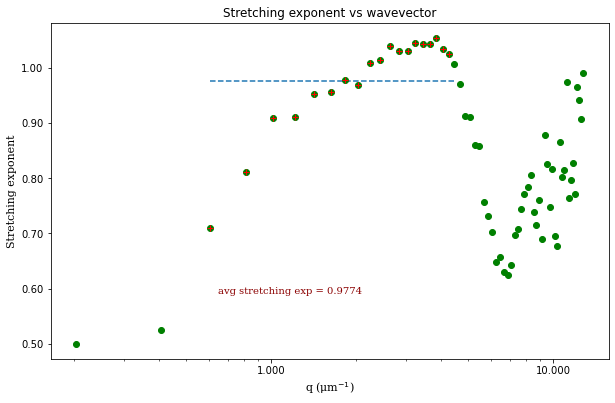

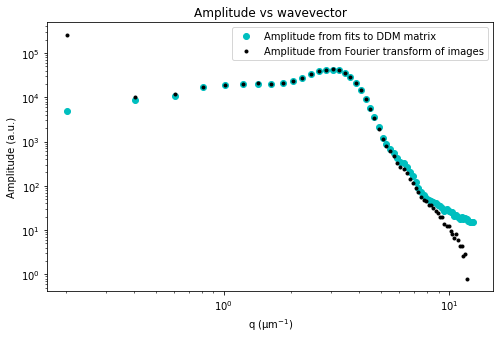

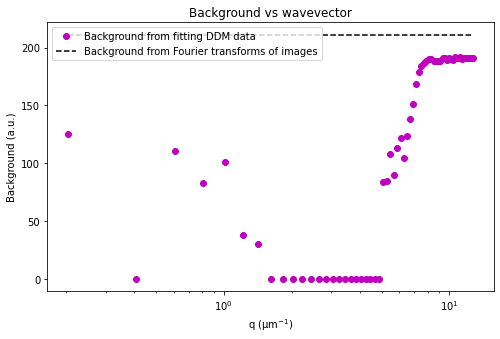

In [19]:
ddm.fit_report(fit01, forced_qs=[3,22])

### 7.2 Inspecting fits {-}

<IPython.core.display.Javascript object>


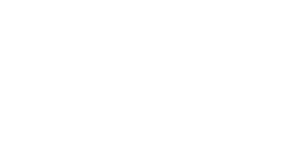

Click on a point in the tau vs q plot to see a fit.
Or press 'N' or 'P' to display next or previous fit.


Text(0, 0.5, 'tau (s)')

In [20]:
%matplotlib notebook
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10,10))
browser = ddm.Browse_DDM_Fits(fig, ax, ax2, fit01)

fig.canvas.mpl_connect('pick_event', browser.on_pick)
fig.canvas.mpl_connect('key_press_event', browser.on_press)

ax.set_title('Decay time vs wavevector')
ax.set_xlabel("q")
ax.set_ylabel("tau (s)")

Using the `Browse_DDM_Fits` class as shown above, one can interactively inspect the fits (to either the DDM matrix or the ISF) by selecting the appropriate point on the $\tau$ vs $q$ plot or by pressing 'N' or 'P' for next or previous. 

### 7.3 Plot decay time vs. wavevector {-}

In hf.plot_one_tau_vs_q function, using new tau... 


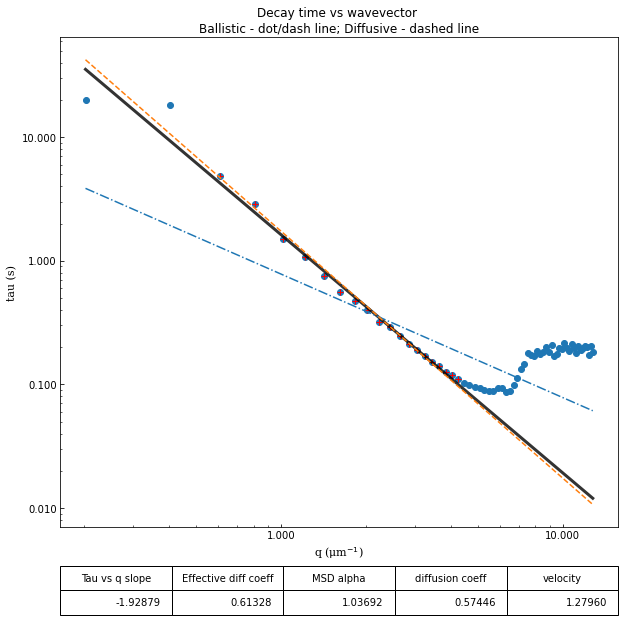

In [21]:
%matplotlib inline
ddm.hf.plot_one_tau_vs_q(fit01, 'tab:blue');

On the log-log plot generated by the function fit_report of $\tau$ vs $q$, three lines are shown corresponding to power law fits over a specified range of $q$ values. The solid black line corresponds to fitting to $\tau = 1/(Kq^\beta)$ where $K$ and $\beta$ are free parameters. The dashed line in orange corresponds to fitting to $\tau = 1/(Dq^2)$ where $D$ is a diffusion coefficient. The dot-dashed line in blue corresponds to fitting to $\tau = 1/(vq)$ where $v$ is a velocity. 

## 8. Saving the results {-}

### 8.1 Save fit results to netCDF format {-}

In [22]:
fit01.to_netcdf("fit_results_single_exponential.nc")

The saved netCDF file can be opened with the xarray function [open_dataset](https://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html).

### 8.2 Save fit results to an Excel file {-}

In [23]:
ddm.save_fit_results_to_excel(fit01)